In [152]:
# necessary imports
import networkx as nx

from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.shifting_field import ShiftingField
from braket.ahs.field import Field
from braket.devices import LocalSimulator

import matplotlib.pyplot as plt
import time
import numpy as np

from scipy import optimize
from iquhack_utils import visualize_graph

In [172]:
blockade_radius = 7.5
np.random.seed(92)

In [173]:
input_graph = np.array([
    [0 , 0, 1, 0, 0],
    [0 , 1, 1, 1, 0],
    [1 , 1, 1, 1, 1],
    [0 , 0, 1, 0, 0],
    ])
input_graph[0,2]

1

In [135]:
rows, columns = input_graph.shape

# Note that it is important for Aquila to maximize the number of atoms in the same row and thus the jj and ii are flipped
scale = 1
atom_list = []
for ii in range(rows):
    for jj in range (columns):
        if input_graph[ii,jj] == 1:
            atom_list.append((jj*scale, ii*scale))

n_atoms = len(atom_list)

# Creating the graph

# Adding the nodes
G = nx.Graph()
for i in range(len(atom_list)):
    G.add_node(i)


# Adding the edges if neighbours/next-nearest neighbours
node_counter = 0
for node in atom_list:

    neighbor_counter = 0
    for neighbor in atom_list:

        #neighbours around the first coordinate
        if (neighbor == (node[0], node[1]-1)) or (neighbor == (node[0], node[1]+1)):
            G.add_edge(node_counter, neighbor_counter)

        #neighbours around the second coordinate
        elif (neighbor == (node[0]-1, node[1])) or (neighbor == (node[0]+1, node[1])):
            G.add_edge(node_counter, neighbor_counter)

        #checking next-nearest neighbors
        elif (neighbor == (node[0]-1, node[1]-1)) or (neighbor == (node[0]-1, node[1]+1)) or (neighbor == (node[0]+1, node[1]-1)) or (neighbor == (node[0]+1, node[1]+1)):
            G.add_edge(node_counter, neighbor_counter)

        neighbor_counter += 1

    node_counter += 1
    #adjacency_matrix.append(adjacency_list)


#print(atom_list)
#print(adjacency_matrix)
#adjacency_matrix = np.array(adjacency_matrix)


#G = nx.Graph(nx.DiGraph(np.array(adjacency_matrix)))
G



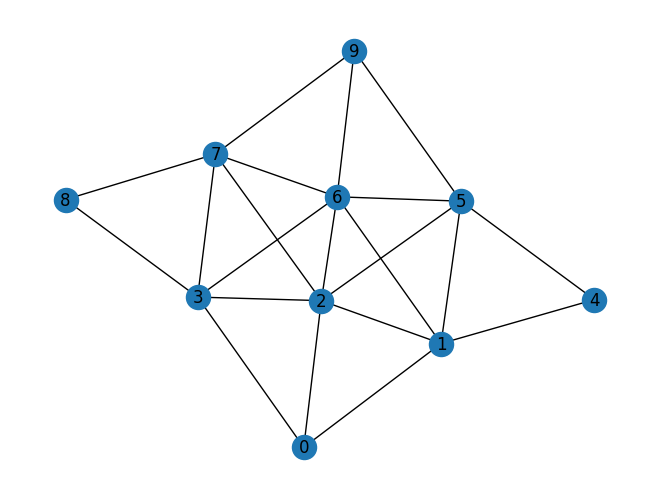

In [138]:
nx.draw(G, with_labels=True)

In [154]:

# this is probably stupid code and there is probably a better way to build the graph but for some reason my brain is just not working today and I spent way too long dong nothing just trying to figure out a smart way to build the network.
# thus this is the fastest way I came up with to recycle their code

def generate_unit_disk_graph(input_graph , scale=4.0*1e-6):

    rows, columns = input_graph.shape

    # Note that it is important for Aquila to maximize the number of atoms in the same row and thus the jj and ii are flipped
    #scale = 1
    atom_list = []
    for ii in range(rows):
        for jj in range (columns):
            if input_graph[ii,jj] == 1:
                atom_list.append((jj, ii))

    n_atoms = len(atom_list)

    # Creating the graph

    # Adding the nodes
    G = nx.Graph()
    for i in range(len(atom_list)):
        G.add_node(i)


    # Adding the edges if neighbours/next-nearest neighbours
    node_counter = 0
    for node in atom_list:

        neighbor_counter = 0
        for neighbor in atom_list:

            #neighbours around the first coordinate
            if (neighbor == (node[0], node[1]-1)) or (neighbor == (node[0], node[1]+1)):
                G.add_edge(node_counter, neighbor_counter)

            #neighbours around the second coordinate
            elif (neighbor == (node[0]-1, node[1])) or (neighbor == (node[0]+1, node[1])):
                G.add_edge(node_counter, neighbor_counter)

            #checking next-nearest neighbors
            elif (neighbor == (node[0]-1, node[1]-1)) or (neighbor == (node[0]-1, node[1]+1)) or (neighbor == (node[0]+1, node[1]-1)) or (neighbor == (node[0]+1, node[1]+1)):
                G.add_edge(node_counter, neighbor_counter)

            neighbor_counter += 1

        node_counter += 1


    atoms = AtomArrangement()
    # for atom in remaining_atom_list:
    for atom in atom_list:
        #atoms.add(atom[0]*scale, atom[1]*scale)
        #print(atom)
        #atoms.add(atom*scale)
        atoms.add(tuple(xi*scale for xi in atom))

    
    return atoms, G


In [155]:
atoms, graph = generate_unit_disk_graph(input_graph)
atoms

In [177]:
def find_UDG_radius(position, graph):
    '''
    Computes the optimal unit disk radius for a particular set of positions and graph.
    position   - [N x 2] array of points
    graph       - network connectivity graph. This should be a unit disk graph.
    
    returns
    radius      - Optimal unit disk radius of the graph
    rmin        - Minimum distance
    rmax        - Maximum distance
    '''
    
    dists = np.sqrt((position[:,0,None] - position[:,0])**2
               + (position[:,1,None] - position[:,1])**2)
    rmin = 0
    rmax = np.inf
    for i in range(position.shape[0]):
        for j in range(i+1,position.shape[0]):
            if (i,j) in graph.edges:
                if rmin<dists[i,j]:
                    rmin = dists[i,j]
            elif (i,j) not in graph.edges:
                if rmax>dists[i,j]:
                    rmax = dists[i,j]
    
    if rmin>rmax:
        print(rmin,rmax)
        raise BaseException("Graph is not a unit disk graph!")
    
    return np.sqrt(rmin*rmax),rmin,rmax

# Find unit disk radius
unitdisk_radius,min_radius,max_radius = find_UDG_radius(pos,small_G)




# Visualize using networkx
fig = plt.figure()
ax = plt.subplot(1,1,1)
visualize_graph(ax,graph,pos)


# Draw the minimum and maximum unit disk radius of the graph
x0,y0 = (2,0)
angles = np.linspace(np.pi/2,np.pi,1001)
ax.plot(min_radius*np.cos(angles)+x0,min_radius*np.sin(angles)+y0,
        linestyle=":",color="red",label="$R_{min}$")
ax.plot(unitdisk_radius*np.cos(angles)+x0,unitdisk_radius*np.sin(angles)+y0,
        linestyle="--",color="red",label="$\sqrt{R_{max}R_{min}}$")
ax.plot(max_radius*np.cos(angles)+x0,max_radius*np.sin(angles)+y0,
        linestyle="-",color="red",label="$R_{max}$")

ax.scatter(x0,y0,color="red",zorder=3,marker="o",s=350)
ax.set_xlim((-0.25,3))
plt.legend(loc="upper right",)
plt.show()

NameError: name 'small_G' is not defined

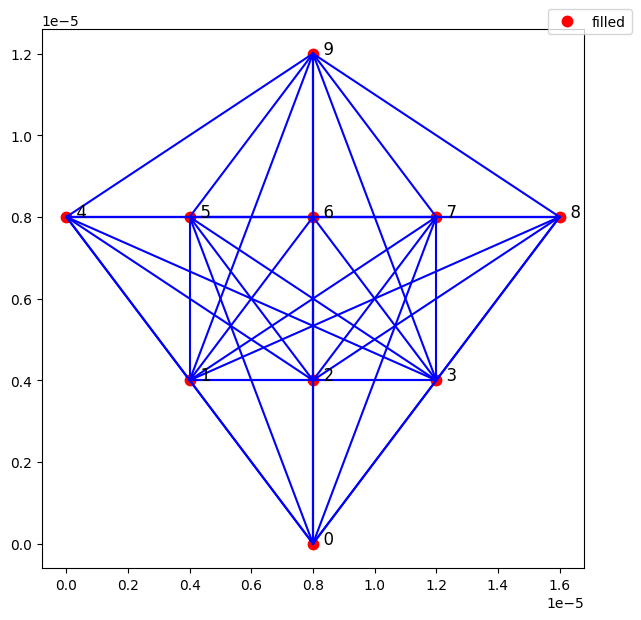

In [178]:
from quera_ahs_utils.plotting import show_register

show_register(atoms, blockade_radius=blockade_radius)

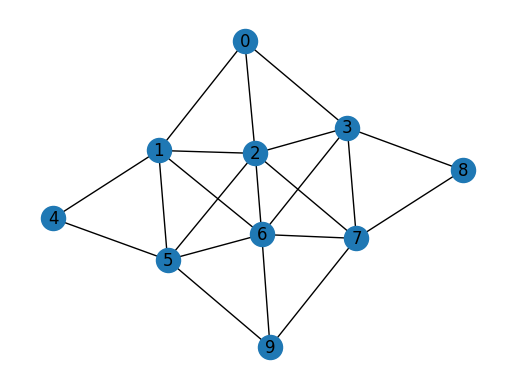

In [180]:
fig, ax = plt.subplots()
#pos = {ii: (ii/atoms_w,ii%atoms_w) for ii in graph.nodes()}
nx.draw(graph, ax=ax, with_labels=True)
plt.show()

In [21]:
def generate_unit_disk_graph(atoms_l: int, atoms_w: int, scale=4.0*1e-6, dropout=0.45):
    atom_list = []
    edge_dict = {}
    atom_to_edge = {}
    for ii in range(atoms_l):
        for jj in range(atoms_w):
            atom_list.append((ii*scale, jj*scale))
            atom_to_edge[(ii*scale, jj*scale)] = ii*atoms_w + jj
            edge_dict[ii*atoms_w + jj] = []
            if jj < atoms_w - 1:
                edge_dict[ii*atoms_w + jj].append(ii*atoms_w + jj + 1)
            if ii < atoms_l - 1:
                edge_dict[ii*atoms_w + jj].append((ii+1)*atoms_w + jj)
            if ii < atoms_l - 1 and jj < atoms_w - 1:
                # nearest neighbor
                edge_dict[ii*atoms_w + jj].append((ii+1)*atoms_w + jj + 1)
            if jj > 0 and ii < atoms_l - 1:
                # nearest neighbor
                edge_dict[ii*atoms_w + jj].append((ii+1)*atoms_w + jj - 1)

    graph = nx.from_dict_of_lists(edge_dict)
    
    # perform dropout
    # new_len = int(np.round(len(atom_list) * (1 - dropout)))
    # atom_arr = np.empty(len(atom_list), dtype=object)
    # atom_arr[:] = atom_list
    # remaining_atom_list = np.random.choice(atom_arr, new_len, replace=False)
    
    dropped_edge_dict = {}
    atoms = AtomArrangement()
    # for atom in remaining_atom_list:
    for atom in atom_list:
        atoms.add(atom)
    graph.remove_nodes_from([atom_to_edge[atom] for atom in  set(atom_list) - set(list(atom_list))])

    return atoms, graph


In [22]:
atoms, graph = generate_unit_disk(atoms_l, atoms_w)

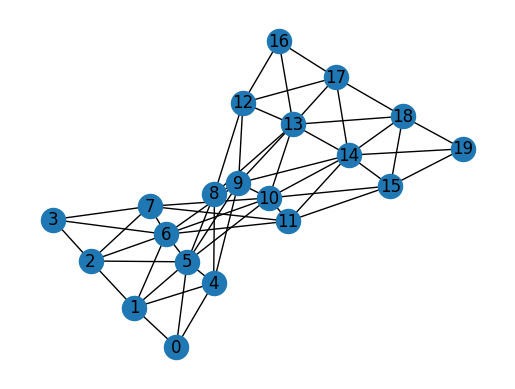

In [100]:
fig, ax = plt.subplots()
#pos = {ii: (ii/atoms_w,ii%atoms_w) for ii in graph.nodes()}
nx.draw(graph, ax=ax, with_labels=True)
plt.show()

In [160]:
def loss_piecewise_linear(atoms: AtomArrangement, x: list):
    assert len(x) == 3
    Delta_start = -13 * 2 * np.pi * 1e6
    Delta_0 = 11 * 2 * np.pi * 1e6
    Delta_end =  11 * 2 * np.pi * 1e6

    Omega_max = 2.5e7 # 4 * 2 * np.pi * 1e6
    T_max = 0.6 * 1e-6

    Deltas = TimeSeries()
    Deltas.put(0.0, Delta_start)
    Deltas.put(0.05 * 1e-6, Delta_start)
    Deltas.put(0.2 * 1e-6, Delta_0 * x[0])
    Deltas.put(0.3 * 1e-6, Delta_0 * x[1])
    Deltas.put(0.4 * 1e-6, Delta_0 * x[2])
    Deltas.put(0.55 * 1e-6, Delta_end)
    Deltas.put(T_max, Delta_end)
    
    # keep amplitude (Rabi frequency) constant once we turn it on
    Omegas = TimeSeries()
    Omegas.put(0.0, 0.0)
    Omegas.put(0.05 * 1e-6, 0.0)
    Omegas.put(0.1 * 1e-6, Omega_max)
    Omegas.put(0.5 * 1e-6, Omega_max)
    Omegas.put(0.55 * 1e-6, 0.0)
    Omegas.put(T_max, 0.0)

    # do not use the phase parameter
    Phi = TimeSeries().put(0.0, 0.0).put(T_max, 0.0)

    # for this problem, our Hamiltonian has no shifting field
    H = DrivingField(amplitude=Omegas, phase=Phi, detuning=Deltas)

    
    program = AnalogHamiltonianSimulation(hamiltonian=H, register=atoms)
    device = LocalSimulator("braket_ahs")
    
    # if you want to use Aquila, uncomment these lines
    # keep in mind that you may have to modify the fields
    #device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
    #program = program.discretize(device)
    
    # run the AHS program and extract measurements
    results = device.run(program, shots=1000, steps=100).result()
    
    
    r_counts = []
    
    # states are one of:
    # 'e' - empty
    # 'r' - Rydberg
    # 'g' - groundstate
    states = ['e', 'r', 'g']
    for shot in results.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state_labels = [states[s_idx] for s_idx in state_idx]
        r_count = np.count_nonzero([sl == 'r' for sl in state_labels])/len(atoms)
        r_counts.append(r_count)

    # the mean density of Rydberg states - this will be our cost
    # higher is better, as it corresponds to a larger independent set
    density_sum = np.mean(r_counts)
    
    return -density_sum, results, Deltas

In [161]:
start = time.time()
# initial waveform parameters
x0 = [0.1, 0.8, 0.8]
initial_rydberg_density, initial_registers, initial_Deltas = loss_piecewise_linear(atoms, x0)
print(f"Initial density: {initial_rydberg_density}")
# perform optimization
optresult = optimize.minimize(lambda x: loss_piecewise_linear(atoms, x)[0], x0, method='Nelder-Mead', options={'maxiter': 10})
final_rydberg_density, final_registers, final_Deltas = loss_piecewise_linear(atoms, optresult.x)
print(f"Final density: {final_rydberg_density}")
print(f"Final values: {optresult.x}")
stop = time.time()
print(f"Time to run AHS with local simulator: {stop-start}")

Initial density: -0.32720000000000005
Final density: -0.32830000000000004
Final values: [0.10322724 0.82776235 0.82507716]
Time to run AHS with local simulator: 1295.5806591510773


Independent set of 1-th most likely outcome


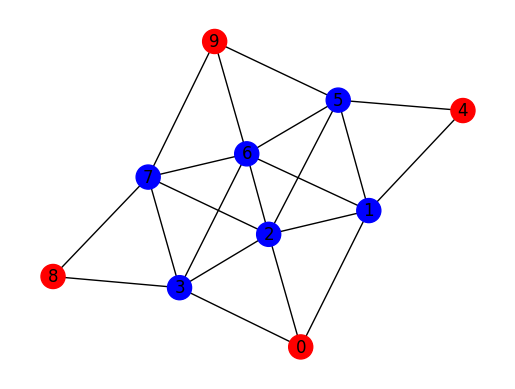

Independent set of 2-th most likely outcome


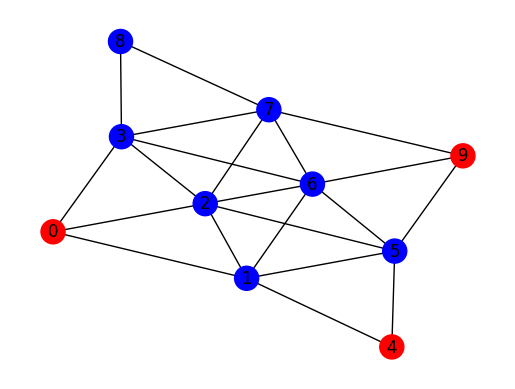

Independent set of 3-th most likely outcome


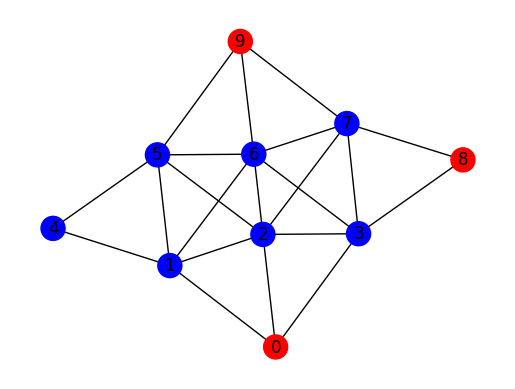

Independent set of 4-th most likely outcome


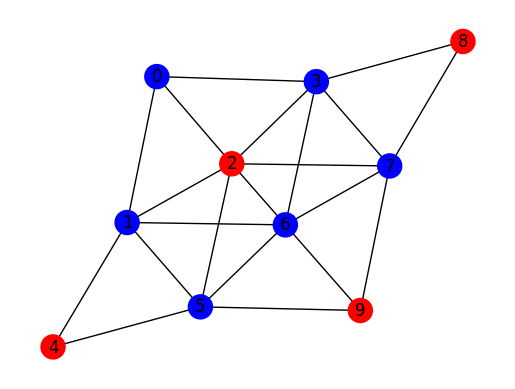

Independent set of 5-th most likely outcome


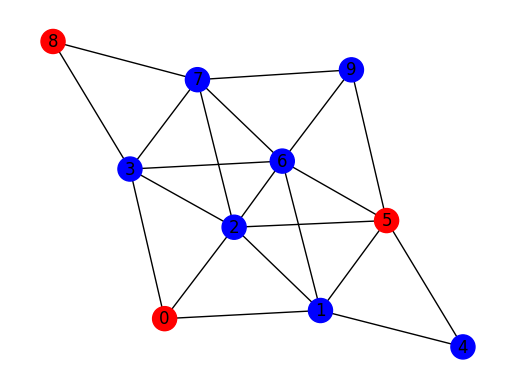

In [168]:
from collections import Counter

states = ['e', 'r', 'g']
state_labels = []
for shot in final_registers.measurements:
    pre = shot.pre_sequence
    post = shot.post_sequence
    state_idx = np.array(pre) * (1 + np.array(post))
    state_labels.append("".join([states[s_idx] for s_idx in state_idx]))

occurence_count = Counter(state_labels)

most_frequent_regs = occurence_count.most_common(5)
for ii in range(len(most_frequent_regs)):
    fig, ax = plt.subplots()
    vert_colors = ['red' if (most_frequent_regs[ii][0][i] == 'r') else 'blue' for i in range(len(most_frequent_regs[ii][0]))]
    print(f'Independent set of {ii+1}-th most likely outcome')
    #nx.draw(graph, pos = {ii: (ii/atoms_w,ii%atoms_w) for ii in graph.nodes()}, ax=ax, with_labels=True, node_color=vert_colors)
    nx.draw(graph, ax=ax, with_labels=True, node_color=vert_colors)
    plt.show()

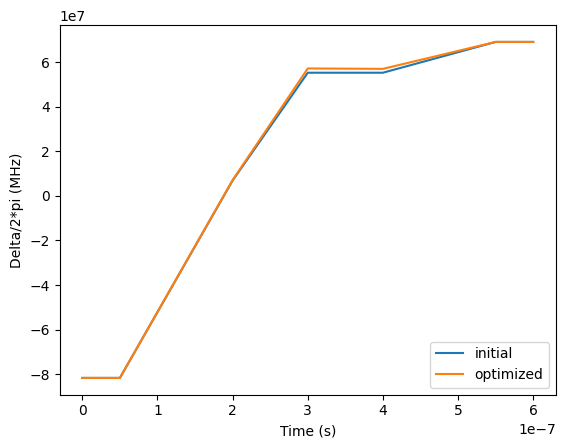

In [167]:
fig, ax = plt.subplots()
ax.plot(initial_Deltas.times(), initial_Deltas.values())
ax.plot(final_Deltas.times(), final_Deltas.values())
ax.set_xlabel("Time (s)")
ax.set_ylabel("Delta/2*pi (MHz)")
ax.legend(["initial", "optimized"], loc="lower right")
plt.show()

In [169]:
def get_counts(result):
    """Aggregate state counts from AHS shot results

    A count of strings (of length = # of spins) are returned, where
    each character denotes the state of a spin (site):
       e: empty site
       u: up state spin
       d: down state spin

    Args:
       result (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult)

    Returns
        dict: number of times each state configuration is measured

    """
    state_counts = Counter()
    states = ['e', 'u', 'd']
    for shot in result.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state = "".join(map(lambda s_idx: states[s_idx], state_idx))
        state_counts.update((state,))
    return dict(state_counts)

counts_simulator = get_counts(final_registers)  # takes about 5 seconds
print(counts_simulator)



{'dddddddddd': 1, 'ddddddddud': 2, 'dddddddduu': 2, 'dddddduddd': 3, 'ddddduddud': 4, 'dddddududd': 3, 'dddduddddd': 1, 'dddduddddu': 1, 'ddddudddud': 7, 'dddduddduu': 33, 'dddduddudd': 2, 'ddddududud': 27, 'dddududddd': 1, 'ddduuddddd': 19, 'ddduuddddu': 9, 'dduddddddd': 1, 'dduddddddu': 1, 'ddudddddud': 1, 'dduddddduu': 3, 'ddududdddd': 1, 'ddududdddu': 1, 'ddududddud': 6, 'ddududdduu': 76, 'dudddddddd': 2, 'dudddddddu': 1, 'duddddddud': 12, 'dudddddduu': 23, 'dudddddudd': 1, 'dududddddd': 12, 'dududddddu': 7, 'uddddddddu': 7, 'udddddddud': 11, 'uddddddduu': 97, 'uddddddudd': 1, 'udddduddud': 68, 'uddddududd': 5, 'uddduddddd': 12, 'uddduddddu': 98, 'udddudddud': 44, 'uddduddduu': 299, 'uddduddudd': 67, 'udddududud': 28}


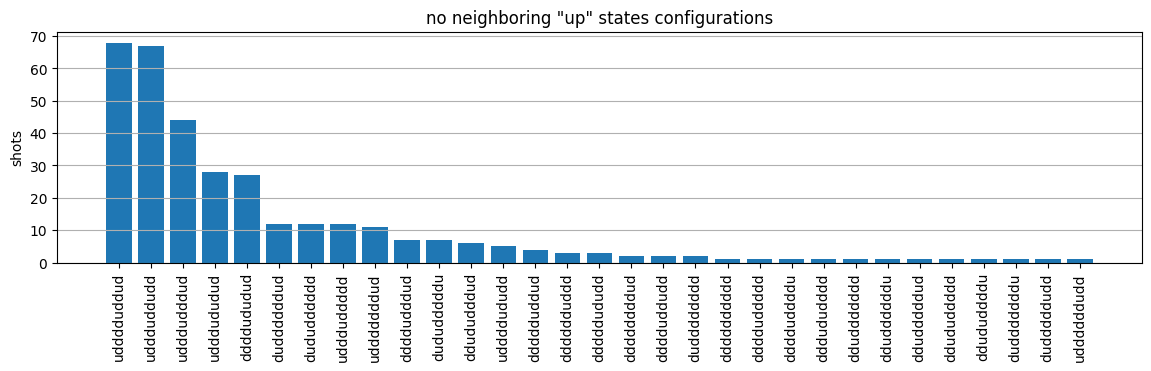

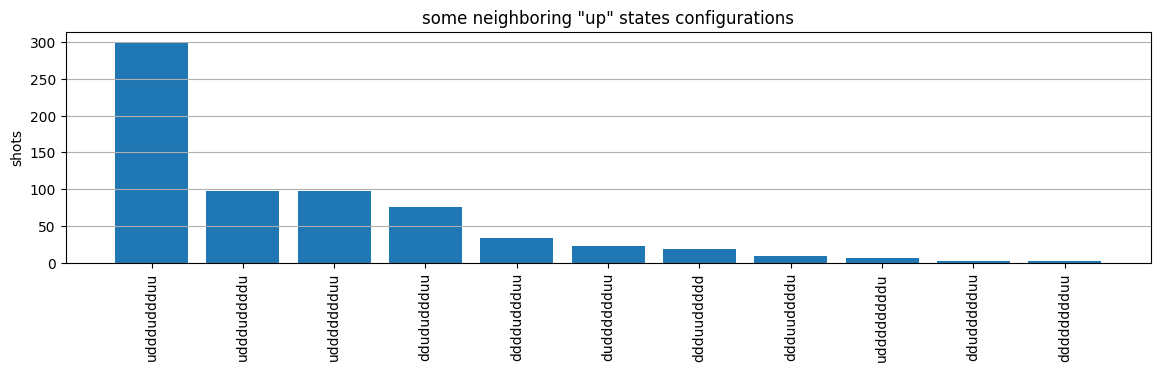

In [170]:
def has_neighboring_up_states(state):
    if 'uu' in state:
        return True
    if state[0] == 'u' and state[-1] == 'u':
        return True
    return False

def number_of_up_states(state):
    return Counter(state)['u']

def plot_counts(counts):
    non_blockaded = []
    blockaded = []
    for state, count in counts.items():
        if not has_neighboring_up_states(state):
            collection = non_blockaded
        else:
            collection = blockaded
        collection.append((state, count, number_of_up_states(state)))

    blockaded.sort(key=lambda _: _[1], reverse=True)
    non_blockaded.sort(key=lambda _: _[1], reverse=True)

    for configurations, name in zip((non_blockaded,
                                    blockaded),
                                    ('no neighboring "up" states',
                                    'some neighboring "up" states')):
        plt.figure(figsize=(14, 3))
        plt.bar(range(len(configurations)), [item[1] for item in configurations])
        plt.xticks(range(len(configurations)))
        plt.gca().set_xticklabels([item[0] for item in configurations], rotation=90)
        plt.ylabel('shots')
        plt.grid(axis='y')
        plt.title(f'{name} configurations')
        plt.show()

plot_counts(counts_simulator)

In [32]:
final_registers.measurements

[ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 0])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 0])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 

In [35]:
from quera_ahs_utils.analysis import get_avg_density
from quera_ahs_utils.plotting import plot_avg_density

#get_avg_density(final_registers)
plot_avg_density(get_avg_density(final_registers), final_registers)

AttributeError: 'AnalogHamiltonianSimulationQuantumTaskResult' object has no attribute 'coordinate_list'